# Testing SFNs
We follow the code from https://github.com/noegroup/stochastic_normalizing_flows/blob/main/experiment1_doublewell.ipynb

# Setup

## Setup Library

In [1]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [2]:
!rm -r stochastic_normalizing_flows
!git clone https://github.com/noegroup/stochastic_normalizing_flows

rm: cannot remove 'stochastic_normalizing_flows': No such file or directory
Cloning into 'stochastic_normalizing_flows'...
remote: Enumerating objects: 147, done.
remote: Counting objects: 100% (147/147), done.
remote: Compressing objects: 100% (128/128), done.
remote: Total 147 (delta 17), reused 136 (delta 11), pack-reused 0
Receiving objects: 100% (147/147), 12.69 MiB | 28.13 MiB/s, done.
Resolving deltas: 100% (17/17), done.


In [21]:
!pip install nflows

     |████████████████████████████████| 45 kB 1.6 MB/s 
  Created wheel for nflows: filename=nflows-0.14-py3-none-any.whl size=53671 sha256=ec4793f39c669fe51fb2349e046e351bd0a6e1d08c2aca38fa66b2ca3d0c6f0d
  Stored in directory: /root/.cache/pip/wheels/c0/b6/52/0092eedabce8f7faa35b92522393fbdc1ec5ede99b0ec820d5
Successfully built nflows


In [3]:
import os
os.listdir()

['.config', 'drive', 'stochastic_normalizing_flows', 'sample_data']

In [4]:
os.chdir("stochastic_normalizing_flows")

In [5]:
!cd bgtorch && python setup.py develop && cd ..
!cd snf_code && python setup.py develop && cd ..

running develop
running egg_info
creating bgtorch.egg-info
writing bgtorch.egg-info/PKG-INFO
writing dependency_links to bgtorch.egg-info/dependency_links.txt
writing top-level names to bgtorch.egg-info/top_level.txt
writing manifest file 'bgtorch.egg-info/SOURCES.txt'
writing manifest file 'bgtorch.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/bgtorch.egg-link (link to .)
Adding bgtorch 0.1 to easy-install.pth file

Installed /content/stochastic_normalizing_flows/bgtorch
Processing dependencies for bgtorch==0.1
Finished processing dependencies for bgtorch==0.1
running develop
running egg_info
writing snf_code.egg-info/PKG-INFO
writing dependency_links to snf_code.egg-info/dependency_links.txt
writing top-level names to snf_code.egg-info/top_level.txt
writing manifest file 'snf_code.egg-info/SOURCES.txt'
running build_ext
Creating /usr/local/lib/python3.7/dist-packages/snf-code.egg-link (link to .)
Adding snf-code 0.1 to easy-install.pth file



## Setup problem

After running the above setups, reload the notebook. Then proceed below

In [5]:
import torch
torch.set_default_dtype(torch.float64)
from bgtorch.utils.types import assert_numpy

In [6]:
from bgtorch.nn.training import KLTrainer

In [7]:
from bgtorch.nn import DenseNet
from bgtorch.nn.flow import (
    SequentialFlow, 
    CouplingFlow, 
    AffineFlow, 
    SplitFlow,
    MergeFlow,
    InverseFlow, 
    SwapFlow
)
from bgtorch.nn.flow.transformer import AffineTransformer

In [8]:
from bgtorch import BoltzmannGenerator

In [9]:
import numpy as np
from matplotlib import pyplot as plt
import matplotlib as mpl

In [10]:
plt.rcParams.update({'font.size': 16})

In [11]:
from bgtorch.distribution import NormalDistribution

In [12]:
from snf_code import InterpolatedEnergy, RNVP, boltzmann_generator_RNVP_MC
from snf_code.analysis import sample_energy, statistical_efficiency
from snf_code.imagetools import boltzmann_generator_NSF_MC

In [13]:
def sample_flow(flow, x0, inverse=False):
    blocks = flow._blocks
    samples = [x0]
    x = [x0]
    if inverse:
        blocks = blocks[::-1]
    for block in blocks:
        *x, ddlogp = block(*x, inverse=inverse)
        if not (isinstance(block, SplitFlow) or isinstance(block, SwapFlow) or isinstance(block, MergeFlow)):
            #print(block)
            x_np = [xi.detach().numpy() for xi in x]
            samples.append(np.hstack(x_np))
    if inverse:
        samples = samples[::-1]
    return samples

# MoG Problem

## Problem defn

In [17]:
def quadratic_function(x, seed=0):
    # example function that we may want to calculate expectations over
    torch.manual_seed(seed)
    x_shift = 2*torch.randn(x.shape[-1]).to(x.device)
    A = 2*torch.rand((x.shape[-1], x.shape[-1])).to(x.device)
    b = torch.rand(x.shape[-1]).to(x.device)
    x = x + x_shift
    return torch.einsum("bi,ij,bj->b", x, A, x) + torch.einsum("i,bi->b", b, x)

In [30]:
class MoG(torch.nn.Module):
    # mog with random mean and var
    def __init__(self, dim : int =2, n_mixes: int =5,
                 min_cov: float=0.5, loc_scaling: float=3.0, diagonal_covariance=True,
                 cov_scaling=1.0, uniform_component_probs = False):
        super(MoG, self).__init__()
        self.dim = dim
        self.n_mixes = n_mixes
        self.distributions = []
        locs = []
        scale_trils = []
        for i in range(n_mixes):
            loc = torch.randn(dim)*loc_scaling
            if diagonal_covariance:
                scale_tril = torch.diag(torch.rand(dim)*cov_scaling + min_cov)
            else:
                # https://stackoverflow.com/questions/58176501/how-do-you-generate-positive-definite-matrix-in-pytorch
                Sigma_k = torch.rand(dim, dim) * cov_scaling + min_cov
                Sigma_k = torch.mm(Sigma_k, Sigma_k.t())
                Sigma_k.add_(torch.eye(dim))
                scale_tril = torch.tril(Sigma_k)
            locs.append(loc[None, :])
            scale_trils.append(scale_tril[None, :, :])

        locs = torch.cat(locs)
        scale_trils = torch.cat(scale_trils)
        if uniform_component_probs:
             self.register_buffer("cat_probs", torch.ones(n_mixes))
        else:
            self.register_buffer("cat_probs", torch.rand(n_mixes))
        self.register_buffer("locs", locs)
        self.register_buffer("scale_trils", scale_trils)
        self.distribution = self.get_distribution
        self.expectation_function = quadratic_function
        #self.true_expectation = MC_estimate_true_expectation(self, self.expectation_function, int(1e6)).item()
        #print(f"true expectation is {self.true_expectation}")

    def to(self, device):
        super(MoG, self).to(device)
        self.distribution = self.get_distribution

    @property
    def get_distribution(self):
        mix = torch.distributions.Categorical(self.cat_probs)
        com = torch.distributions.MultivariateNormal(self.locs, scale_tril=self.scale_trils)
        return torch.distributions.MixtureSameFamily(mixture_distribution=mix, component_distribution=com)

    def log_prob(self, x: torch.Tensor):
        return self.distribution.log_prob(x)

    def energy(self, x, temperature=None):
      return - self.log_prob(x)[:, None]

    def sample(self, shape=(1,)):
        return self.distribution.sample(shape)

    @torch.no_grad()
    def performance_metrics(self, train_class, x_samples, log_w,
                            n_batches_stat_aggregation=10):
        samples_per_batch = x_samples.shape[0] // n_batches_stat_aggregation
        expectations = []
        for i, batch_number in enumerate(range(n_batches_stat_aggregation)):
            if i != n_batches_stat_aggregation - 1:
                log_w_batch = log_w[batch_number * samples_per_batch:(batch_number + 1) * samples_per_batch]
                x_samples_batch = x_samples[batch_number * samples_per_batch:(batch_number + 1) * samples_per_batch]
            else:
                log_w_batch = log_w[batch_number * samples_per_batch:]
                x_samples_batch = x_samples[batch_number * samples_per_batch:]
            expectation = train_class.AIS_train.\
                estimate_expectation_given_samples_and_log_w(self.expectation_function,
                                                             x_samples_batch, log_w_batch).item()
            expectations.append(expectation)
        bias_normed = np.abs(np.mean(expectations) - self.true_expectation) / self.true_expectation
        std_normed = np.std(expectations) / self.true_expectation
        summary_dict = {"bias_normed": bias_normed, "std_normed": std_normed}
        long_dict = {}
        return summary_dict, long_dict

## Let's go

In [41]:
seed=2
dim=2

In [42]:
assert seed == 2
assert dim == 2
torch.set_default_dtype(torch.float64)
torch.manual_seed(seed)
target = MoG(dim=dim, n_mixes=5, min_cov=1, loc_scaling=10)

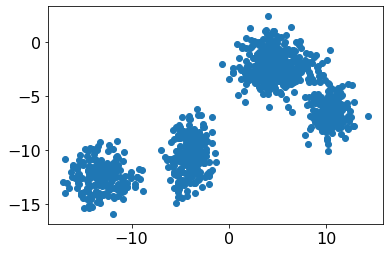

In [43]:
samples = target.sample((1000,)).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], "o")

In [44]:
target.energy(target.sample((100,))).shape

torch.Size([100, 1])

In [50]:
prior = NormalDistribution(2)
bg_unbiased_MC2 = boltzmann_generator_RNVP_MC(prior, target, n_transform=3, shift_nhidden=[64, 64], scale_nhidden=[64, 64],
                                                 nrelax=20, stepsize=0.25, stochastic=True, diffuse_at_0=True)
trainer = KLTrainer(bg_unbiased_MC2, train_likelihood=False, train_energy=True,
                        optim=torch.optim.Adam(bg_unbiased_MC2.parameters(), lr=0.005))

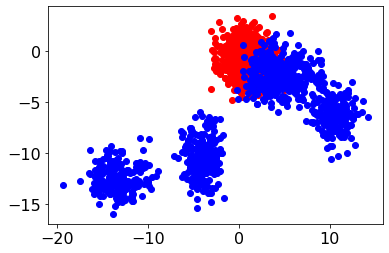

In [51]:
samples = bg_unbiased_MC2.sample(1000).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], "or")
samples = target.sample((1000,)).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], "ob")

In [52]:
trainer.train(1000, data=None, batchsize=128, w_likelihood=0.0, w_energy=1.0, n_print=50)

1	KLL: 7.3955	
51	KLL: 3.7429	
101	KLL: 3.7867	
151	KLL: 3.7497	
201	KLL: 3.7126	
251	KLL: 3.8047	
301	KLL: 3.4136	
351	KLL: 3.8328	
401	KLL: 3.7245	
451	KLL: 3.6594	
501	KLL: 3.4685	
551	KLL: 3.5546	
601	KLL: 3.5764	
651	KLL: 3.6816	
701	KLL: 3.5806	
751	KLL: 3.5604	
801	KLL: 3.6782	
851	KLL: 3.7960	
901	KLL: 3.5422	
951	KLL: 3.7097	


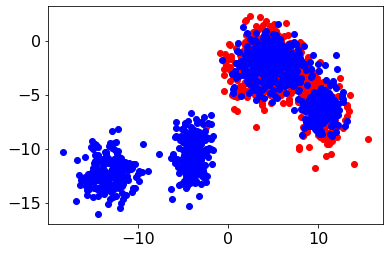

In [53]:
samples = bg_unbiased_MC2.sample(1000).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], "or")
samples = target.sample((1000,)).detach().numpy()
plt.plot(samples[:, 0], samples[:, 1], "ob")